### 🚀 **`Questions & Answers`**

In [1]:
from matplotlib import pyplot as plt 
import seaborn as sns

import pandas as pd 
import config
import psycopg2
import warnings

warnings.filterwarnings('ignore')
sns.set_style("dark")

In [2]:
## Abro conexión
conn = psycopg2.connect(
    dbname = config.DATABASE,
    user = config.USER, 
    password = config.PASS,
    host = "localhost",
    port = "5432"
)

#### 📌 `Pregunta 1.`

¿ Cómo influyen los ingresos y el monto de crédito solicitado en la probabilidad de incumplimiento ?

In [3]:
## Query 
preg_01 = pd.read_sql_query("""
WITH income_credit_bins AS (
  SELECT 
    SK_ID_CURR,
    TARGET,
    NTILE(10) OVER (ORDER BY AMT_INCOME_TOTAL) AS income_decile,
    NTILE(10) OVER (ORDER BY AMT_CREDIT) AS credit_decile
  FROM application_train
)
SELECT 
  income_decile,
  credit_decile,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM income_credit_bins
GROUP BY income_decile, credit_decile
ORDER BY income_decile, credit_decile;
""", conn)

In [4]:
heatmap_data = preg_01.pivot(index = "income_decile", columns = "credit_decile", values = "default_rate")

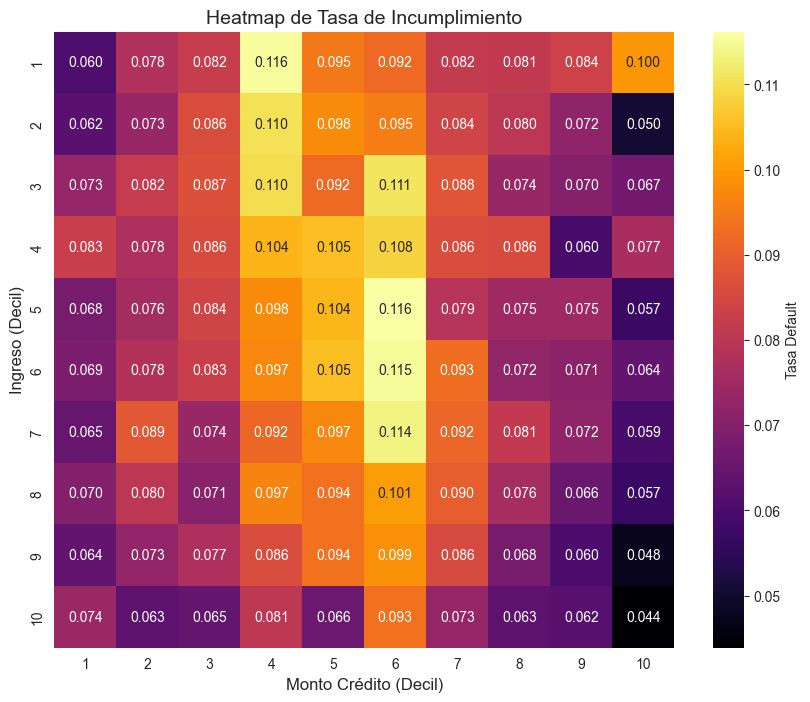

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot = True, fmt = ".3f", cmap = "inferno", cbar_kws = {'label': 'Tasa Default'})
plt.title("Heatmap de Tasa de Incumplimiento", fontsize = 14)
plt.xlabel("Monto Crédito (Decil)", fontsize = 12)
plt.ylabel("Ingreso (Decil)", fontsize = 12)
plt.savefig('./figs/preg01.png', dpi = 300)
plt.show()

**`Respuesta`**: De acuerdo al heatmap, se puede apreciar los clientes con ingresos bajos y créditos moderados presentan mayor riesgo, mientras que los clientes con ingresos altos y créditos altos tienen menor probabilidad de incumplir. Esto puede ser útil para segmentar clientes y ajustar políticas de crédito.

#### 📌 `Pregunta 2.`

¿Los clientes con créditos previos en otras instituciones tienen un menor riesgo de incumplimiento ? 

In [6]:
## Query
preg_02 = pd.read_sql_query("""
WITH bureau_flags AS (
  SELECT 
    SK_ID_CURR,
    COUNT(*) AS total_bureau_records
  FROM bureau
  GROUP BY SK_ID_CURR
),
flags_joined AS (
  SELECT 
    a.SK_ID_CURR,
    a.TARGET,
    CASE WHEN b.total_bureau_records IS NULL THEN 0 ELSE 1 END AS has_bureau_record
  FROM application_train a
  LEFT JOIN bureau_flags b ON a.SK_ID_CURR = b.SK_ID_CURR
)
SELECT 
  has_bureau_record,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM flags_joined
GROUP BY has_bureau_record;
""", conn)

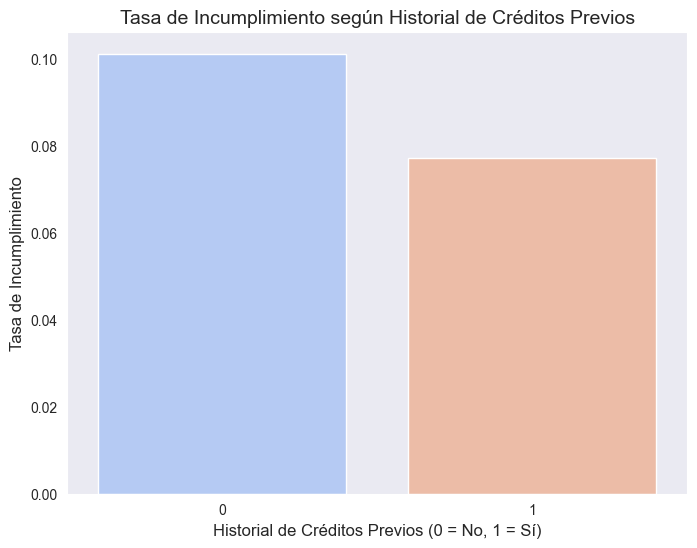

In [7]:
plt.figure(figsize = (8, 6))
sns.barplot(
    x = "has_bureau_record", 
    y = "default_rate", 
    data = preg_02, 
    palette = "coolwarm")
plt.title("Tasa de Incumplimiento según Historial de Créditos Previos", fontsize = 14)
plt.xlabel("Historial de Créditos Previos (0 = No, 1 = Sí)", fontsize = 12)
plt.ylabel("Tasa de Incumplimiento", fontsize = 12)
plt.savefig('./figs/preg02.png', dpi = 300)
plt.show()

**`Respuesta`:** Los datos muestran que los clientes con historial de créditos previos tienen una menor tasa de incumplimiento en comparación con aquellos que no tienen historial, lo que podría indicar que el historial de créditos previos es un factor positivo para evaluar el riesgo de incumplimiento.

#### 📌 `Pregunta 3.`

¿Cómo influye el tipo de crédito solicitado en la tasa de incumplimiento ? 

In [8]:
## Query
preg_03 = pd.read_sql_query("""
SELECT 
  NAME_CONTRACT_TYPE,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM application_train
GROUP BY NAME_CONTRACT_TYPE
ORDER BY default_rate DESC;
""", conn)

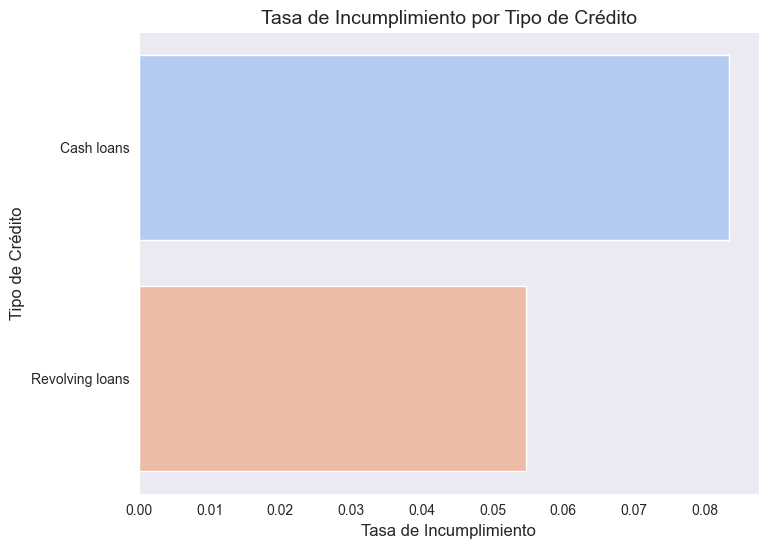

In [9]:
plt.figure(figsize = (8, 6))
sns.barplot(
    x = "default_rate", 
    y = "name_contract_type", 
    data = preg_03.sort_values(by = "default_rate", ascending = False), 
    palette = "coolwarm")
plt.title("Tasa de Incumplimiento por Tipo de Crédito", fontsize = 14)
plt.xlabel("Tasa de Incumplimiento", fontsize = 12)
plt.ylabel("Tipo de Crédito", fontsize = 12)
plt.savefig('./figs/preg03.png', dpi = 300)
plt.show()

**`Respuesta`:** El barplot muestra que el tipo de crédito solicitado tiene una influencia significativa en la tasa de incumplimiento. En el caso de `cash loans`, al tener una tasa de incumplimiento más alta, indica que clientes que solicitan préstamos en efectivo, tienen mayor probabilidad de incumplir. Por otro lado,  `revolving loans` tienen tasas más bajas lo cual sugiere que clientes que solicitan créditos renovables tienen menor riesgo de incumplimiento.

#### 📌 `Pregunta 4.`

¿Existe una relación entre el saldo actual en la tarjeta de crédito y el incumplimiento? 

In [10]:
## Query
preg_04 = pd.read_sql_query("""
WITH credit_balance AS (
  SELECT 
    SK_ID_CURR,
    AVG(AMT_BALANCE) AS avg_balance
  FROM credit_card_balance
  GROUP BY SK_ID_CURR
),
balance_bins AS (
  SELECT 
    a.SK_ID_CURR,
    a.TARGET,
    NTILE(10) OVER (ORDER BY c.avg_balance) AS balance_decile
  FROM application_train a
  LEFT JOIN credit_balance c ON a.SK_ID_CURR = c.SK_ID_CURR
)
SELECT 
  balance_decile,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM balance_bins
GROUP BY balance_decile
ORDER BY balance_decile;
""", conn)

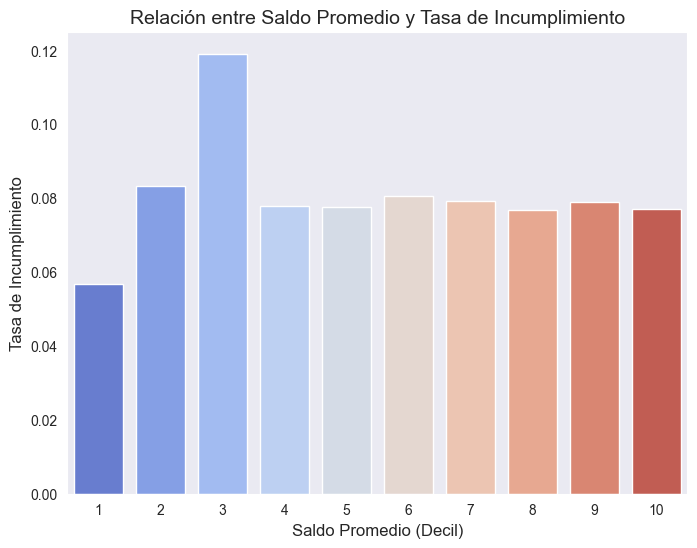

In [11]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x = "balance_decile", 
    y = "default_rate", 
    data = preg_04, 
    palette = "coolwarm")
plt.title("Relación entre Saldo Promedio y Tasa de Incumplimiento", fontsize = 14)
plt.xlabel("Saldo Promedio (Decil)", fontsize = 12)
plt.ylabel("Tasa de Incumplimiento", fontsize = 12)
plt.savefig('./figs/preg04.png', dpi = 300)
plt.show()

**`Respuesta`:** De acuerdo al gráfico anterior, podemos notar que no estan clara la relación. Esto, es porque solo el decil 3 es el que presenta mayor tasa de incumplimiento, mientras que los deciles restantes (particularmente, decil 4 en adelante) presentan tasas de incumplimiento similares (aprox 8%). 

#### 📌 `Pregunta 5.`

¿Los clientes con altos niveles de uso de líneas de crédito tienen mayor riesgo de default ?

In [12]:
## Query
preg_05 = pd.read_sql_query("""
WITH credit_usage AS (
  SELECT 
    SK_ID_CURR,
    AVG(AMT_BALANCE / NULLIF(AMT_CREDIT_LIMIT_ACTUAL, 0)) AS avg_utilization
  FROM credit_card_balance
  WHERE AMT_CREDIT_LIMIT_ACTUAL > 0
  GROUP BY SK_ID_CURR
),
usage_bins AS (
  SELECT 
    a.SK_ID_CURR,
    a.TARGET,
    NTILE(10) OVER (ORDER BY c.avg_utilization) AS utilization_decile
  FROM application_train a
  LEFT JOIN credit_usage c ON a.SK_ID_CURR = c.SK_ID_CURR
)
SELECT 
  utilization_decile,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM usage_bins
GROUP BY utilization_decile
ORDER BY utilization_decile;
""", conn)

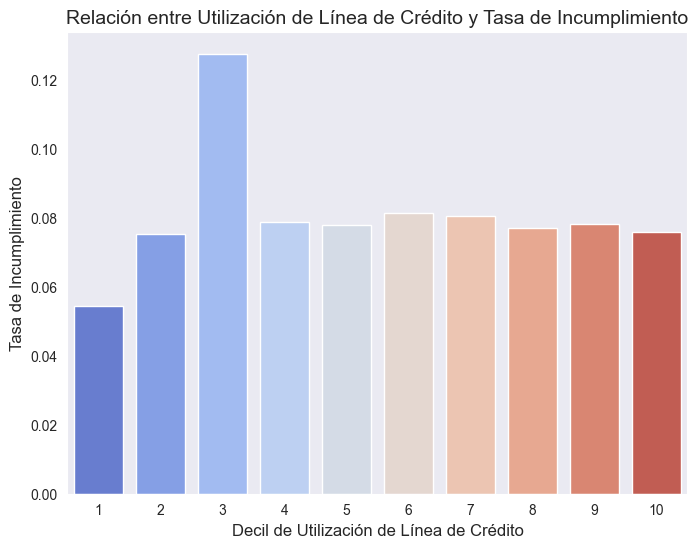

In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x = "utilization_decile", 
    y = "default_rate", 
    data = preg_05, 
    palette = "coolwarm")
plt.title("Relación entre Utilización de Línea de Crédito y Tasa de Incumplimiento", fontsize = 14)
plt.xlabel("Decil de Utilización de Línea de Crédito", fontsize = 12)
plt.ylabel("Tasa de Incumplimiento", fontsize = 12)
plt.savefig('./figs/preg05.png', dpi = 300)
plt.show()

**`Respuesta`:** Notar que la grafica anterior, es similar al de la pregunta 05. El comportamiento similar en ambas gráficas refleja cómo el saldo promedio y la utilización de la línea de crédito son indicadores relacionados del riesgo de incumplimiento. Ambos factores están vinculados a la capacidad de pago, el nivel de endeudamiento y los hábitos financieros de los clientes. Por otro lado, el saldo promedio en la tarjeta de crédito (`AMT_BALANCE`) está directamente relacionado con la utilización de la línea de crédito (`AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL`). Si un cliente tiene un saldo alto, es probable que esté utilizando una mayor proporción de su límite de crédito, lo que explica el comportamiento similar en ambas gráficas.

#### 📌 `Pregunta 6.`

¿Los clientes cuyos créditos previos fueron rechazados tienen una mayor probabilidad de incumplir en futuras solicitudes ?

In [14]:
## Query
preg_06 = pd.read_sql_query("""
WITH refused_clients AS (
  SELECT 
    SK_ID_CURR,
    COUNT(*) AS refused_count
  FROM previous_application
  WHERE NAME_CONTRACT_STATUS = 'Refused'
  GROUP BY SK_ID_CURR
),
clients_flagged AS (
  SELECT 
    a.SK_ID_CURR,
    a.TARGET,
    CASE WHEN r.refused_count IS NOT NULL THEN 1 ELSE 0 END AS had_refusals
  FROM application_train a
  LEFT JOIN refused_clients r ON a.SK_ID_CURR = r.SK_ID_CURR
)
SELECT 
  had_refusals,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM clients_flagged
GROUP BY had_refusals;
""", conn)

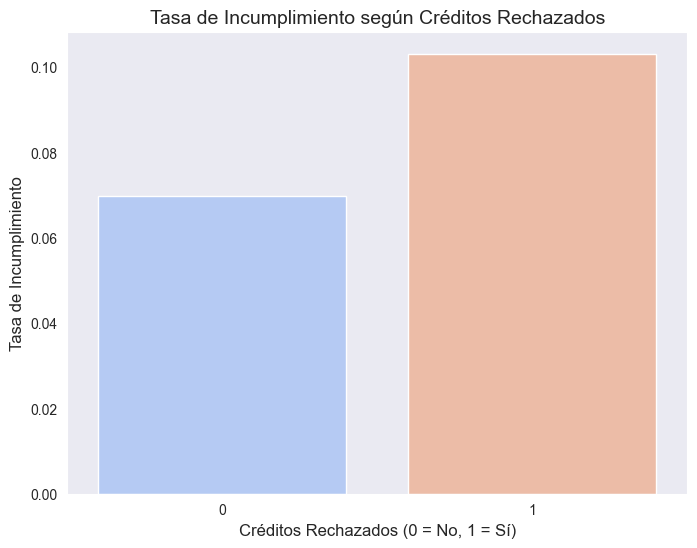

In [15]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x = "had_refusals", 
    y = "default_rate", 
    data = preg_06, 
    palette = "coolwarm")
plt.title("Tasa de Incumplimiento según Créditos Rechazados", fontsize = 14)
plt.xlabel("Créditos Rechazados (0 = No, 1 = Sí)", fontsize = 12)
plt.ylabel("Tasa de Incumplimiento", fontsize = 12)
plt.savefig('./figs/preg06.png', dpi = 300)
plt.show()

**`Respuesta`:** Sí, los clientes cuyos créditos previos fueron rechazados tienen una mayor probabilidad de incumplir en futuras solicitudes, como lo demuestra la diferencia en las tasas de incumplimiento entre ambos grupos.

#### 📌 `Pregunta 7.`

¿Cuál es la tasa de default de clientes que viven con su familia (`NAME_TYPE_SUITE = 'Family'`) y que tienen al menos un hijo (`CNT_CHILDREN > 0`), en comparación con quienes viven solos y sin hijos, segmentado por deciles de ingreso ?

In [16]:
## Query
preg_07 = pd.read_sql_query("""
WITH labeled_clients AS (
  SELECT 
    SK_ID_CURR,
    TARGET,
    AMT_INCOME_TOTAL,
    CASE 
      WHEN NAME_TYPE_SUITE = 'Family' AND CNT_CHILDREN > 0 THEN 'With_Family_and_Children'
      WHEN NAME_TYPE_SUITE = 'Unaccompanied' AND CNT_CHILDREN = 0 THEN 'Alone_No_Children'
      ELSE 'Other'
    END AS group_type
  FROM application_train
),
income_deciles AS (
  SELECT *,
    NTILE(10) OVER (ORDER BY AMT_INCOME_TOTAL) AS income_decile
  FROM labeled_clients
)
SELECT 
  group_type,
  income_decile,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM income_deciles
WHERE group_type IN ('With_Family_and_Children', 'Alone_No_Children')
GROUP BY group_type, income_decile
ORDER BY group_type, income_decile;
""", conn)

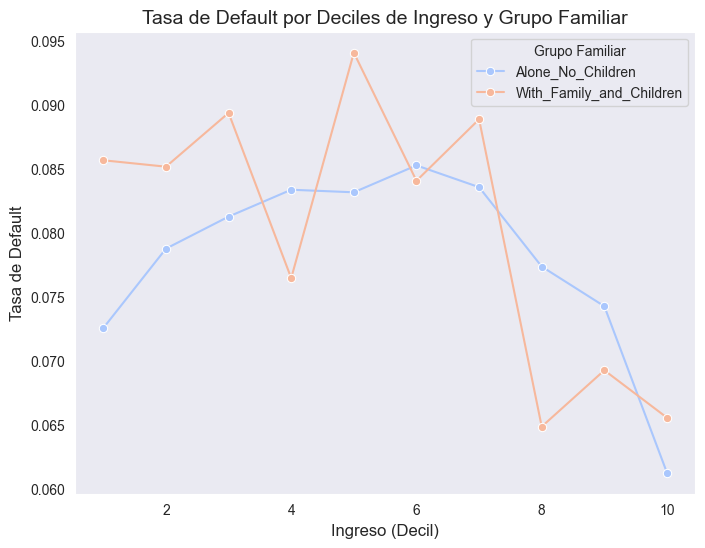

In [17]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    x = "income_decile", 
    y = "default_rate", 
    hue = "group_type", 
    data = preg_07, 
    marker = "o", 
    palette = "coolwarm")
plt.title("Tasa de Default por Deciles de Ingreso y Grupo Familiar", fontsize = 14)
plt.xlabel("Ingreso (Decil)", fontsize = 12)
plt.ylabel("Tasa de Default", fontsize = 12)
plt.legend(title = "Grupo Familiar")
plt.savefig('./figs/preg07.png', dpi = 300)
plt.show()

**`Respuesta`:** Los clientes que viven con su familia y tienen al menos un hijo presentan una mayor tasa de default en comparación con quienes viven solos y sin hijos, especialmente en los deciles bajos y medios de ingreso. Esto sugiere que el perfil familiar y el nivel de ingreso son factores importantes para evaluar el riesgo de incumplimiento.

#### 📌 `Pregunta 8.`

¿Cómo varía la tasa de default entre personas que viven en departamentos alquilados o comunales y tienen educación secundaria o menor, en comparación con quienes son propietarios con educación superior, segmentado por deciles de ingreso?


In [18]:
## Query
preg_08 = pd.read_sql_query("""
WITH categorized_clients AS (
  SELECT 
    SK_ID_CURR,
    TARGET,
    AMT_INCOME_TOTAL,
    CASE 
      WHEN NAME_HOUSING_TYPE IN ('Rented apartment', 'Municipal apartment') 
        AND NAME_EDUCATION_TYPE IN ('Secondary / secondary special', 'Lower secondary') 
        THEN 'Low_Edu_Rent'
      WHEN NAME_HOUSING_TYPE = 'House / apartment' 
        AND NAME_EDUCATION_TYPE = 'Higher education'
        THEN 'High_Edu_Owner'
      ELSE 'Other'
    END AS profile_type
  FROM application_train
),
income_deciles AS (
  SELECT *,
    NTILE(10) OVER (ORDER BY AMT_INCOME_TOTAL) AS income_decile
  FROM categorized_clients
)
SELECT 
  profile_type,
  income_decile,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM income_deciles
WHERE profile_type IN ('Low_Edu_Rent', 'High_Edu_Owner')
GROUP BY profile_type, income_decile
ORDER BY profile_type, income_decile;
""", conn)

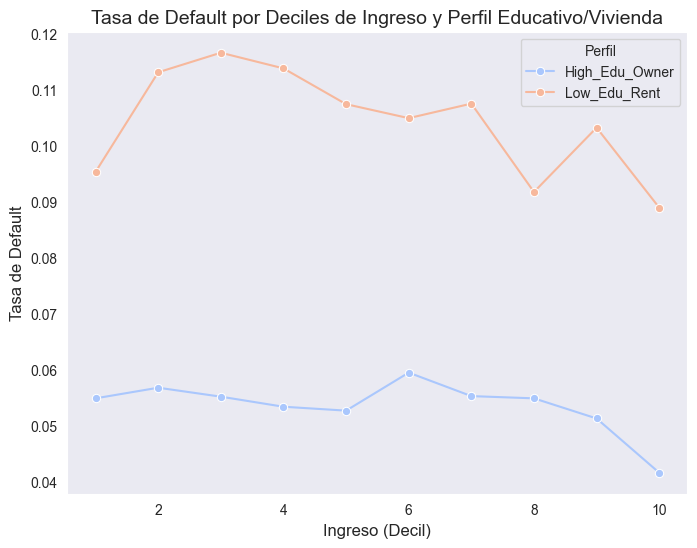

In [19]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    x = "income_decile", 
    y = "default_rate", 
    hue = "profile_type", 
    data = preg_08, 
    marker = "o", 
    palette = "coolwarm")
plt.title("Tasa de Default por Deciles de Ingreso y Perfil Educativo/Vivienda", fontsize = 14)
plt.xlabel("Ingreso (Decil)", fontsize = 12)
plt.ylabel("Tasa de Default", fontsize = 12)
plt.legend(title = "Perfil")
plt.savefig('./figs/preg08.png', dpi = 300)
plt.show()

**`Respuesta`:** Las personas que viven en departamentos alquilados o comunales y tienen educación secundaria o menor presentan una mayor tasa de default en comparación con quienes son propietarios con educación superior, especialmente en los deciles bajos de ingreso. Esto refuerza la importancia de considerar el perfil educativo y la situación de vivienda al evaluar el riesgo de incumplimiento.

In [20]:
# Cierre conexión
conn.close()